Data source: https://datashare.is.ed.ac.uk/handle/10283/392 

Example audio file from: http://www.voiptroubleshooter.com/open_speech/american.html

Processing code from: https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html

In [59]:
import numpy as np
import scipy.io.wavfile
from scipy.fftpack import dct

In [60]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 15})

In [61]:
def fix_ticks(actual, step = 1, n_labels = None, axis = 0):
    # Function to re-label x (axis == 0) or y (axis == 1) ticks when using imshow
    # actual is an array of the same length as the number of pixels along the axis
    # step is the numerical distance between ticks in the units of actual
    # alternately, n_labels is the number of labels to use - they will be evenly spaced
    
    n_pixels = len(actual)
    tick_range = actual[-1] - actual[0]
    if n_labels is not None:
        tick_step = int(n_pixels/n_labels)
    else:
        tick_step = int(n_pixels/(tick_range/step))
    positions = np.arange(0,n_pixels,tick_step) # pixel count at label position
    labels = actual[::tick_step] # labels you want to see
    if axis == 0:
        plt.xticks(positions, labels)
    else:
        plt.yticks(positions, labels)

In [62]:
class Speech_Processor:
    def load_audio(self, path_and_file, label = 'Audio File'):
        self.label = label
        self.source = path_and_file
        self.sample_rate, self.signal = scipy.io.wavfile.read(path_and_file)
        self.length = len(self.signal)/self.sample_rate
        self.time = np.arange(len(self.signal))/self.sample_rate
        self.emphasized = False
    
    def truncate(self, start = 0, end = 3.5):
        self.signal = self.signal[int(self.sample_rate * start):int(self.sample_rate * end)]
        self.time   = self.time[int(self.sample_rate * start):int(self.sample_rate * end)]
        self.length = len(self.signal)/self.sample_rate
        
    def emphasize(self, pre_emphasis = 0.97):
        self.signal = np.append(self.signal[0], self.signal[1:] - pre_emphasis * self.signal[:-1])
        self.emphasized = True
    

    def framing_and_window(self, frame_size = 0.025, frame_stride = 0.01):
        frame_length, frame_step = frame_size * self.sample_rate, frame_stride * self.sample_rate  # Convert from seconds to samples
        signal_length = len(self.signal)
        frame_length = int(round(frame_length))
        frame_step = int(round(frame_step))
        num_frames = int(np.ceil(float(np.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

        pad_signal_length = num_frames * frame_step + frame_length
        z = np.zeros((pad_signal_length - signal_length))
        pad_signal = np.append(self.signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

        indices = np.tile(np.arange(0, frame_length), (num_frames, 1)) + np.tile(np.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
        frames = pad_signal[indices.astype(np.int32, copy=False)]
        frames *= np.hamming(frame_length)
        frame_times = np.arange(frames.shape[0]) * frame_stride + self.time[0] # convert back to seconds
        
        self.frames = frames
        self.frame_times = frame_times
        
    def plot_signal(self, fig = None):
        if fig is None:
            fig = plt.figure(figsize = (15, 3))
        _ = plt.plot(self.time, self.signal)
        _ = plt.ylabel('Amplitude')
        _ = plt.title(self.label)
        if self.emphasized:
            _ = fig.suptitle('Emphasized signal', fontsize = 24)
        else:
            _ = fig.suptitle('Raw signal', fontsize = 24)
        
    def fourier_and_power(self, NFFT = 512):
        self.NFFT = NFFT
        self.mag_frames = np.absolute(np.fft.rfft(self.frames, self.NFFT))  # Magnitude of the FFT
        self.pow_frames = ((1.0 / self.NFFT) * ((self.mag_frames) ** 2))  # Power Spectrum
    
    def make_filter_banks(self, nfilt = 40):
        low_freq_mel = 0
        high_freq_mel = (2595 * np.log10(1 + (self.sample_rate / 2) / 700))  # Convert Hz to Mel
        mel_points = np.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
        hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
        bin = np.floor((self.NFFT + 1) * hz_points / self.sample_rate)

        fbank = np.zeros((nfilt, int(np.floor(self.NFFT / 2 + 1))))
        for m in range(1, nfilt + 1):
            f_m_minus = int(bin[m - 1])   # left
            f_m = int(bin[m])             # center
            f_m_plus = int(bin[m + 1])    # right

            for k in range(f_m_minus, f_m):
                fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
            for k in range(f_m, f_m_plus):
                fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
        filter_banks = np.dot(self.pow_frames, fbank.T)
        filter_banks = np.where(filter_banks == 0, np.finfo(float).eps, filter_banks)  # Numerical Stability
        filter_banks = 20 * np.log10(filter_banks)  # dB
        self.filter_banks = filter_banks
        self.filter_banks_norm = False

    def make_mfcc(self, num_ceps = 12, sinu_lift = True, cep_lifter = 22):
        if self.filter_banks_norm:
            raise Exception('self.filter_banks has already been normalized')
        mfcc = dct(self.filter_banks, type=2, axis=1, norm='ortho')[:, 1 : (num_ceps + 1)] # Keep 2-13
        if sinu_lift:
            (nframes, ncoeff) = mfcc.shape
            n = np.arange(ncoeff)
            lift = 1 + (cep_lifter / 2) * np.sin(np.pi * n / cep_lifter)
            mfcc *= lift
        self.mfcc = mfcc
        self.mfcc_norm = False

    def mean_norm(self, filter_banks = True, mfcc = True):
        if filter_banks:
            self.filter_banks -= (np.mean(self.filter_banks, axis=0) + 1e-8)
            self.filter_banks_norm = True
        if mfcc:
            self.mfcc -= (np.mean(self.mfcc, axis=0) + 1e-8)
            self.mfcc_norm = True
            
    def plot_filter_banks(self, x_tick_step = 1, fig = None):
        if fig is None:
            fig = plt.figure(figsize = (15, 3))
        if self.filter_banks_norm:
            _ = fig.suptitle('Mean Normalized Filter Banks', fontsize = 24)
        else:
            _ = fig.suptitle('Filter Banks', fontsize = 24)
            
        y = np.arange(self.filter_banks.shape[1])/10
        _ = plt.imshow(self.filter_banks.T, cmap = 'Spectral_r', aspect = 'auto', origin='lower') 
        _ = plt.ylabel('Frequency (kHz)')
        _ = fix_ticks(self.frame_times, step = x_tick_step, axis = 0)
        _ = fix_ticks(y, step = 1, axis = 1)
        _ = plt.title(self.label)

    def plot_mfcc(self, x_tick_step = 1, fig = None):
        if fig is None:
            fig = plt.figure(figsize = (15, 3))
        if self.mfcc_norm:
            _ = fig.suptitle('Mean Normalized MFCC', fontsize = 24)
        else:
            _ = fig.suptitle('MFCC', fontsize = 24)
            
        _ = plt.imshow(self.mfcc.T, cmap = 'Spectral_r', aspect = 'auto', origin='lower') 
        _ = plt.ylabel('MFCC Coefficients')
        _ = fix_ticks(self.frame_times, step = x_tick_step, axis = 0)
        _ = plt.title(self.label)

In [63]:
data_folder = 'data/dataset_arthur-the-rat/'

audio_files = {'Sample audio OSR_us_000_0010_8k'      : data_folder + 'Audio test/OSR_us_000_0010_8k.wav',
               'R0482: 24yo American (Midwest) woman' : data_folder + 'Arthur the Rat (recordings 476-500)/R0482.wav',
               'R0483: 26yo American (Midwest) man'   : data_folder + 'Arthur the Rat (recordings 476-500)/R0483.wav',
               'R0498: 18yo Edinburgh man'            : data_folder + 'Arthur the Rat (recordings 476-500)/R0498.wav',
               'R0502: 38yo Japanese man'             : data_folder + 'Arthur the Rat (recordings 501-525)/R0502.wav',
               'R0073: 28yo Hungarian man'             : data_folder + 'Arthur the Rat (recordings 51-75)/R0073.wav'}

n_files = len(audio_files)
figsize = (15, 4 * n_files)

In [64]:
audio_data = []
start_times = [0, 1.5, 3.5, 13.4, 16, 9.75]
trunc_length = 7
i = 0
for name, path in audio_files.items():
    p = Speech_Processor()
    p.load_audio(path, label = name)
    print('Loaded    %-31s: length %.2f s, sample rate %5d Hz.' %(p.label, p.length, p.sample_rate))
    p.truncate(start = start_times[i], end = start_times[i] + trunc_length)
    i += 1
    print('Truncated %-31s: new length %.2f s.' %(p.label, p.length))
    print()
    audio_data.append(p)


Loaded    Sample audio OSR_us_000_0010_8k: length 33.62 s, sample rate  8000 Hz.
Truncated Sample audio OSR_us_000_0010_8k: new length 7.00 s.

Loaded    R0482: 24yo American (Midwest) woman: length 132.55 s, sample rate 48000 Hz.
Truncated R0482: 24yo American (Midwest) woman: new length 7.00 s.

Loaded    R0483: 26yo American (Midwest) man: length 128.00 s, sample rate 48000 Hz.
Truncated R0483: 26yo American (Midwest) man: new length 7.00 s.

Loaded    R0498: 18yo Edinburgh man      : length 131.57 s, sample rate 48000 Hz.
Truncated R0498: 18yo Edinburgh man      : new length 7.00 s.

Loaded    R0502: 38yo Japanese man       : length 153.48 s, sample rate 48000 Hz.
Truncated R0502: 38yo Japanese man       : new length 7.00 s.

Loaded    R0073: 28yo Hungarian man      : length 114.61 s, sample rate 48000 Hz.
Truncated R0073: 28yo Hungarian man      : new length 7.00 s.



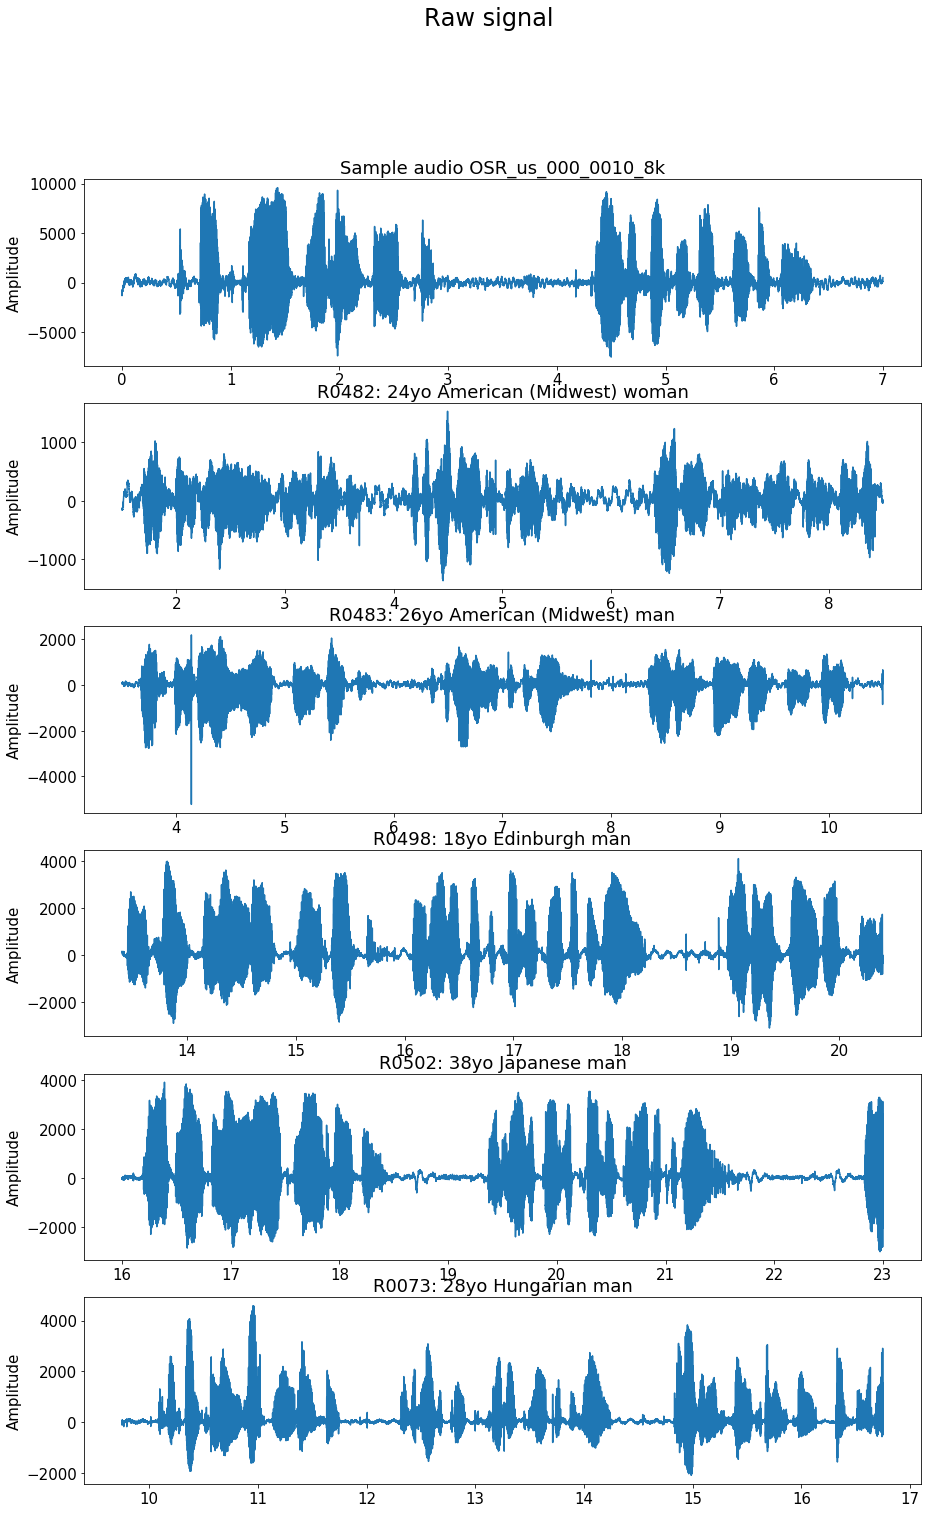

In [65]:
f = plt.figure(figsize = figsize)
k = 1
for p in audio_data:
    _ = plt.subplot(n_files, 1, k)
    p.plot_signal(fig = f)
    k += 1

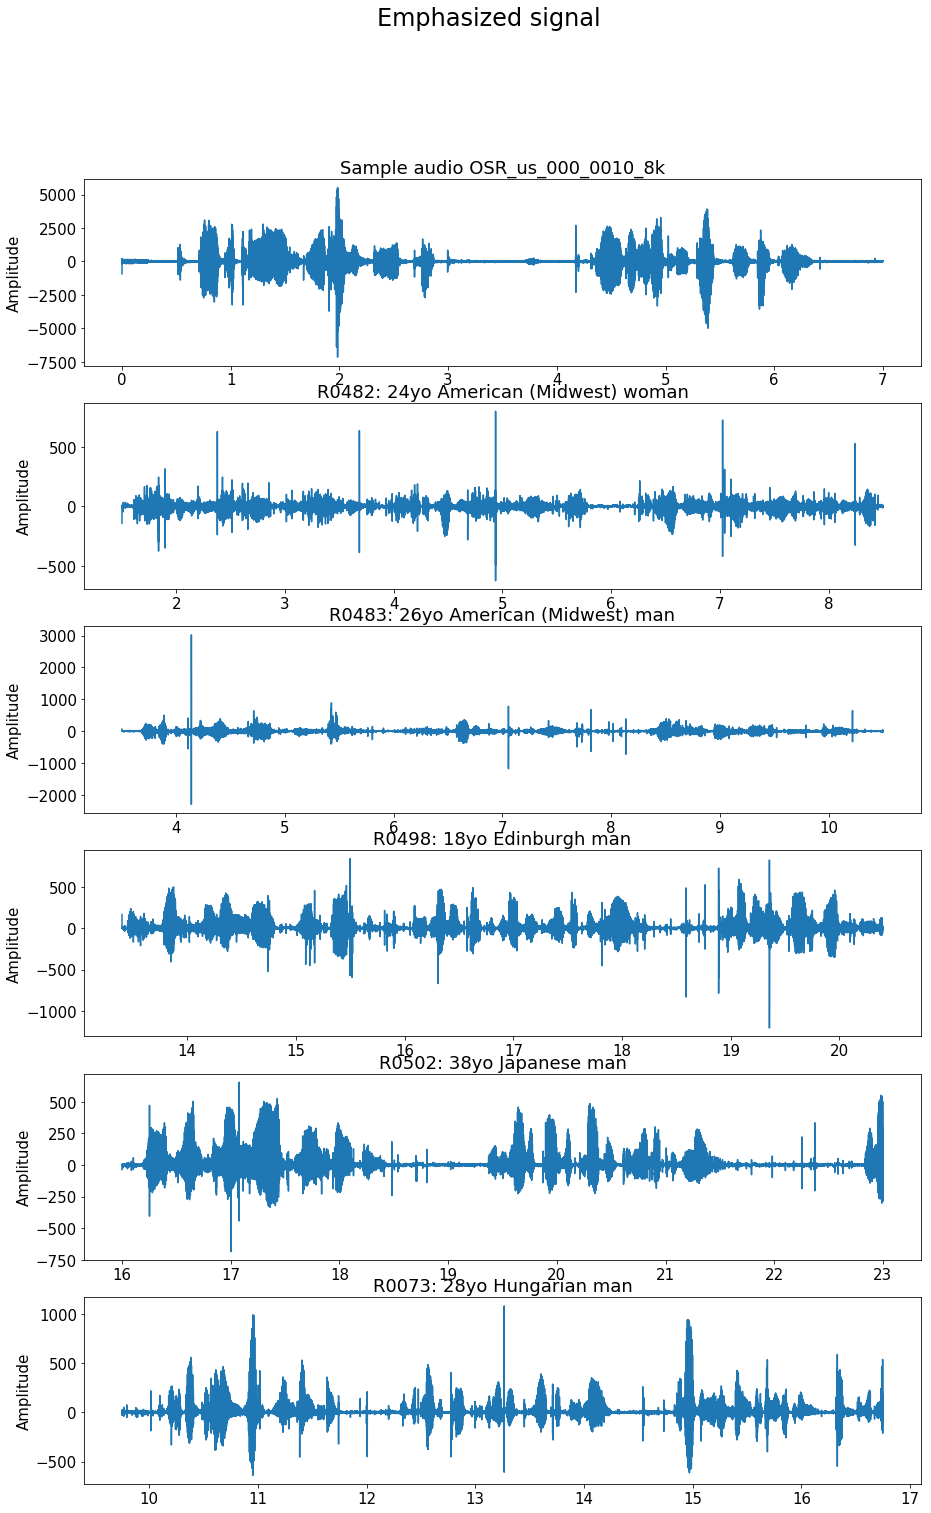

In [66]:
f = plt.figure(figsize = figsize)
k = 1
for p in audio_data:
    _ = plt.subplot(n_files, 1, k)
    p.emphasize()
    p.plot_signal(fig = f)
    k += 1

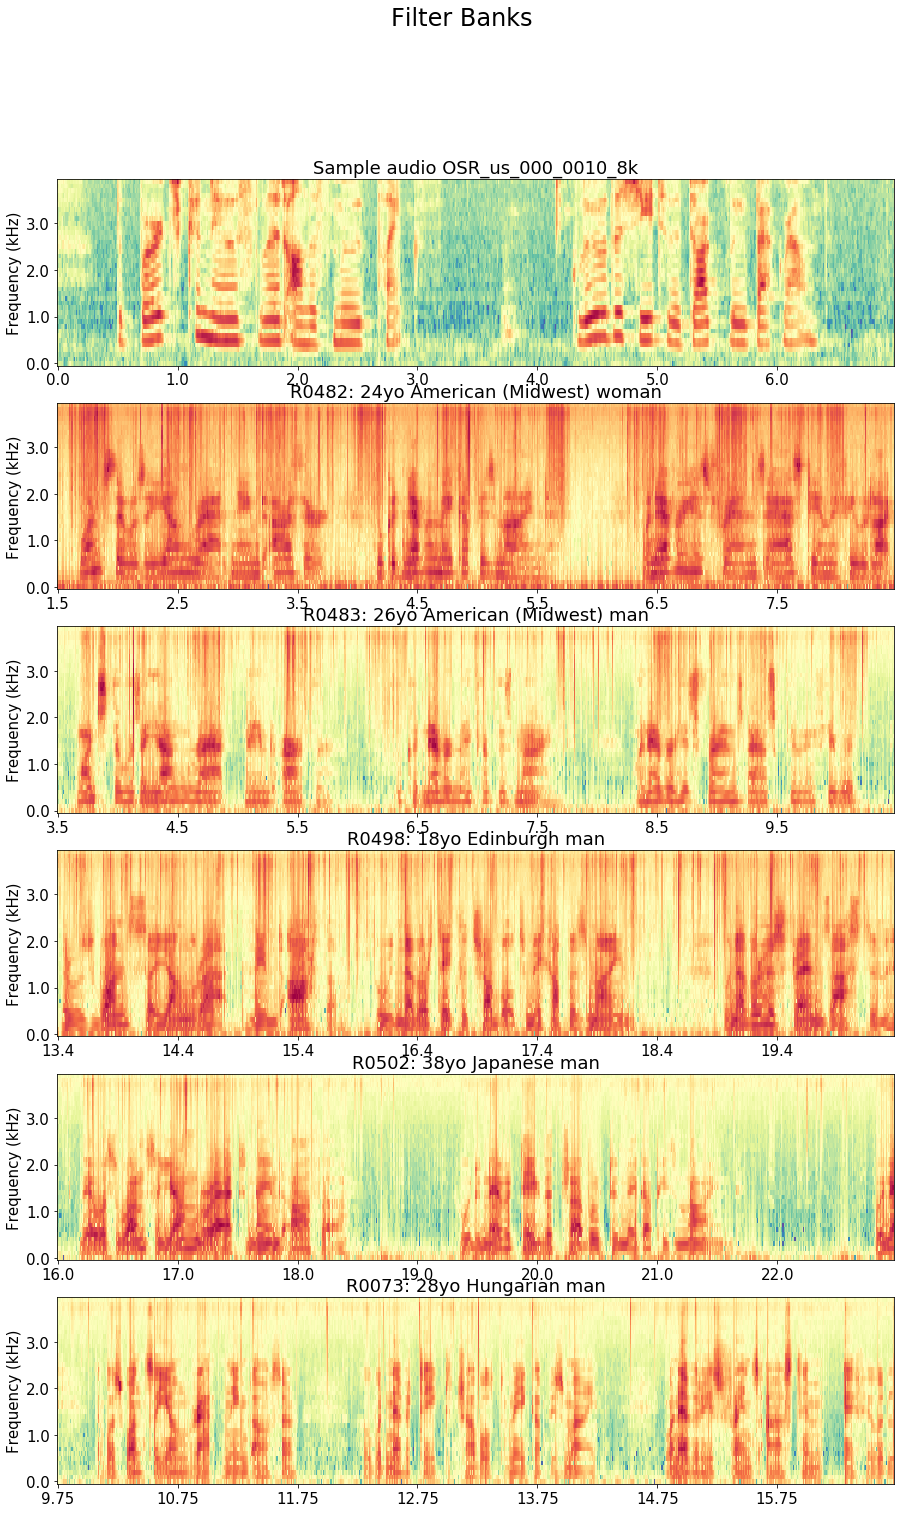

In [67]:
f = plt.figure(figsize = figsize)
k = 1
for p in audio_data:
    _ = plt.subplot(n_files, 1, k)
    p.framing_and_window()
    p.fourier_and_power()
    p.make_filter_banks()
    p.make_mfcc()
    p.plot_filter_banks(fig = f)
    k += 1

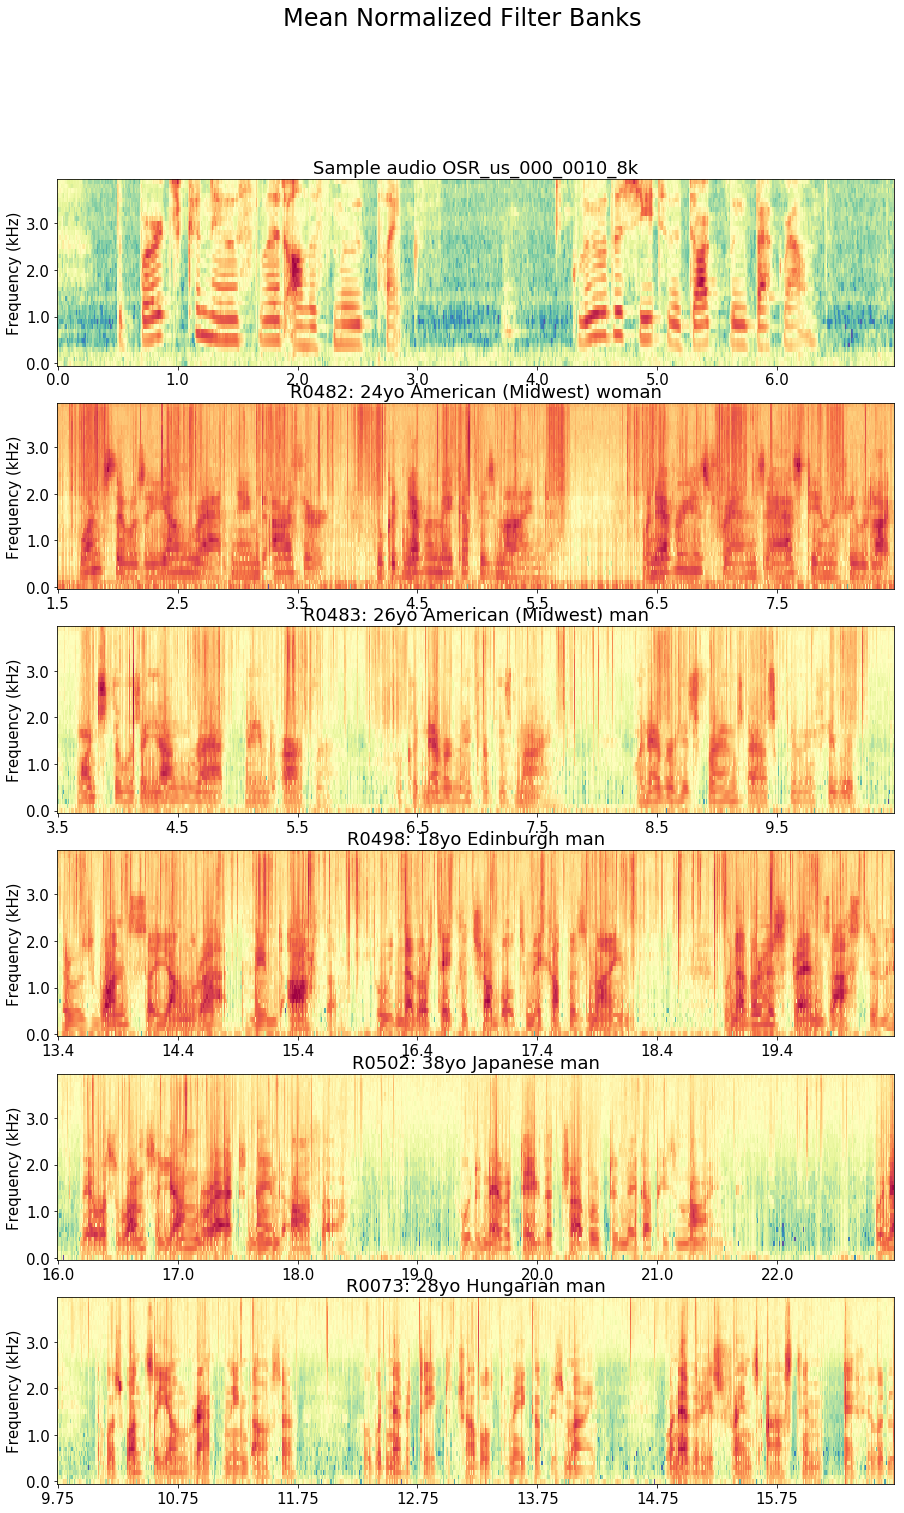

In [68]:
f = plt.figure(figsize = figsize)
k = 1
for p in audio_data:
    _ = plt.subplot(n_files, 1, k)
    p.mean_norm()
    p.plot_filter_banks(fig = f)
    k += 1

plt.savefig('Capstone2_0_ArthurTheRat_MNFBexample_2.png')

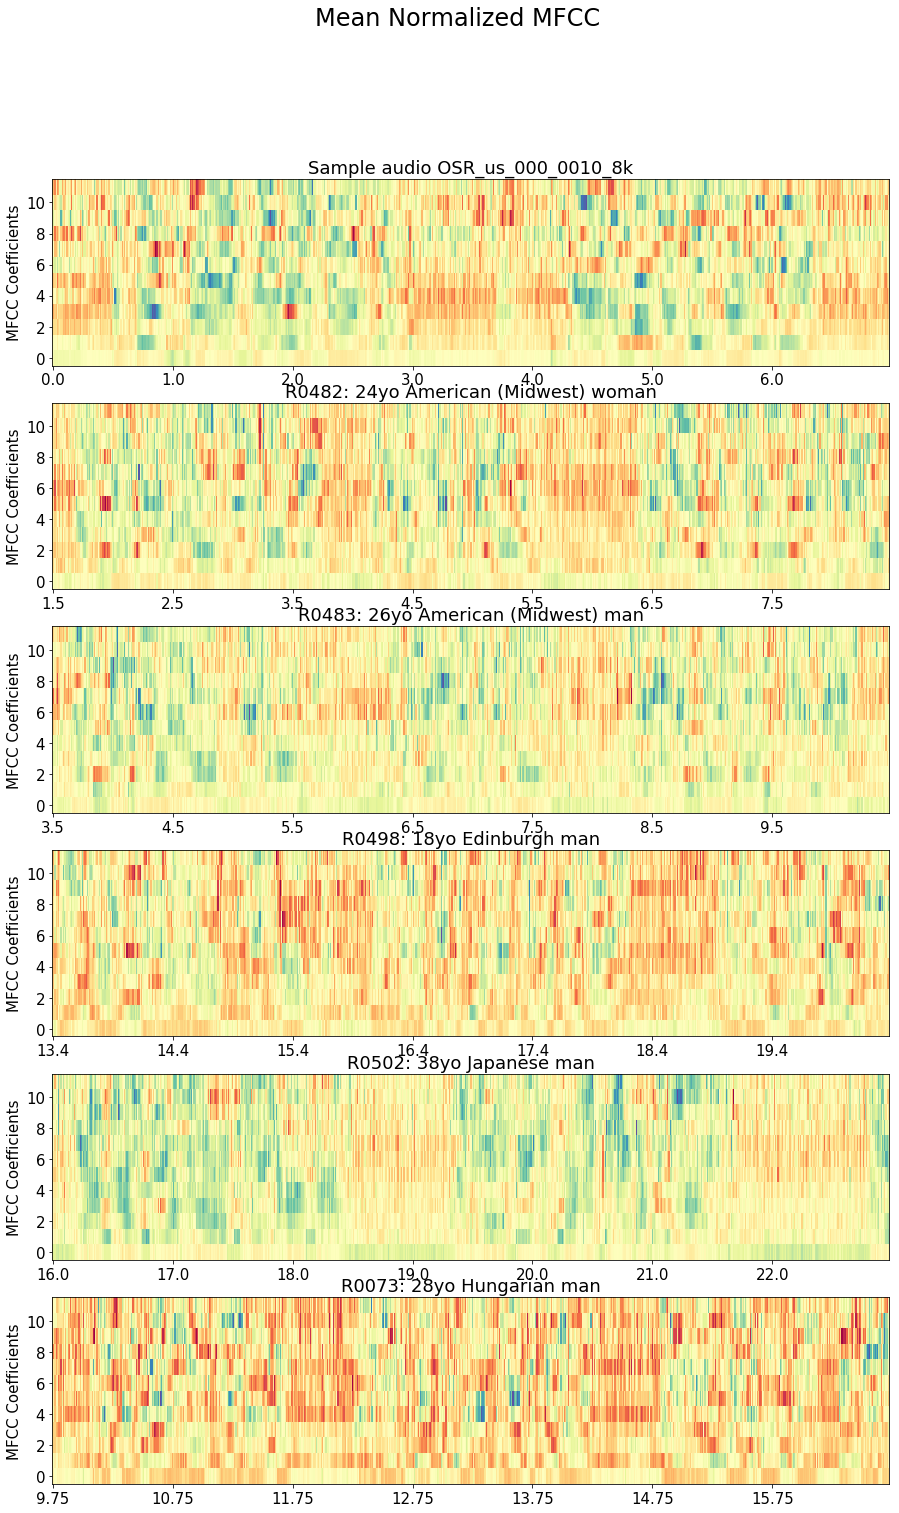

In [69]:
f = plt.figure(figsize = figsize)
k = 1
for p in audio_data:
    _ = plt.subplot(n_files, 1, k)
    p.plot_mfcc(fig = f)
    k += 1